<a href="https://colab.research.google.com/github/sandstorm12/RubikaInterviewExam/blob/dev/rubika_interview_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Try oversampling using augmentation

In [16]:
#@title System check { form-width: "20%" }

!nvidia-smi

Tue Sep 14 11:34:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    58W / 149W |   5422MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
#@title Installation { form-width: "20%" }

!pip3 install focal-loss

In [2]:
#@title Imports { form-width: "20%"}

import numpy as np
import tensorflow as tf

from sklearn.metrics import classification_report

In [3]:
#@title Load dataset { form-width: "20%" }

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("x_train: {} y_train: {} x_test: {} y_test: {}".format(
        x_train.shape, y_train.shape, x_test.shape, y_test.shape
    )
)

print("x_train --> max: {} mean: {} min: {}".format(
        np.max(x_train), np.mean(x_train), np.min(x_train)
    )
)

print("y_train --> unique_values: {}".format(
        np.unique(y_train)
    )
)

x_train: (50000, 32, 32, 3) y_train: (50000, 1) x_test: (10000, 32, 32, 3) y_test: (10000, 1)
x_train --> max: 255 mean: 120.70756512369792 min: 0
y_train --> unique_values: [0 1 2 3 4 5 6 7 8 9]


In [4]:
#@title Preprocessing { form-width: "20%" }

x_train_preprocessed = tf.keras.applications.densenet.preprocess_input(x_train)
x_test_preprocessed = tf.keras.applications.densenet.preprocess_input(x_test)

print("x_train --> max: {} mean: {} min: {}".format(
        np.max(x_train_preprocessed),
        np.mean(x_train_preprocessed),
        np.min(x_train_preprocessed)
    )
)

x_train --> max: 2.640000104904175 mean: 0.10828698426485062 min: -2.1179039478302


In [5]:
#@title One class classification { form-width: "20%" }

selected_class = 0

y_train_one_class = y_train.copy()
y_train_one_class[y_train == selected_class] = 0
y_train_one_class[y_train != selected_class] = 1

y_test_one_class = y_test.copy()
y_test_one_class[y_test == selected_class] = 0
y_test_one_class[y_test != selected_class] = 1

print(np.unique(y_train_one_class))
print(np.unique(y_test_one_class))

[0 1]
[0 1]


In [12]:
#@title Build model { form-width: "20%" }

model = tf.keras.Sequential()

model.add(
    tf.keras.applications.DenseNet121(
        include_top=False,
        weights="imagenet",
        input_shape=(32, 32, 3),
    )
)

for layer in model.layers:
    layer.trainable = False

model.add(
    tf.keras.layers.Flatten()
)

model.add(
    tf.keras.layers.Dense(256, activation="relu")
)

model.add(
    tf.keras.layers.Dense(64, activation="relu")
)

model.add(
    tf.keras.layers.Dense(2, activation="softmax")
)

adam = tf.keras.optimizers.Adam(learning_rate=.0001)

# from focal_loss import SparseCategoricalFocalLoss
# loss_func = SparseCategoricalFocalLoss(gamma=2)
loss_func = "sparse_categorical_crossentropy"

model.compile(
    loss=loss_func,
    optimizer=adam,
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1, 1, 1024)        7037504   
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 7,316,482
Trainable params: 278,978
Non-trainable params: 7,037,504
_________________________________________________________________


In [42]:
model = tf.keras.Sequential()

model.add(
    tf.keras.layers.InputLayer((32, 32, 3))
)

model.add(
     tf.keras.layers.Conv2D(32, (3, 3))
)
model.add(
     tf.keras.layers.Conv2D(32, (3, 3))
)
model.add(
     tf.keras.layers.MaxPool2D((2, 2))
)

model.add(
     tf.keras.layers.Conv2D(64, (3, 3))
)
model.add(
     tf.keras.layers.Conv2D(64, (3, 3))
)
model.add(
     tf.keras.layers.MaxPool2D((2, 2))
)

# model.add(
#      tf.keras.layers.Conv2D(32, (3, 3))
# )
# model.add(
#      tf.keras.layers.Conv2D(32, (3, 3))
# )
# model.add(
#      tf.keras.layers.MaxPool2D((2, 2))
# )

model.add(
    tf.keras.layers.Flatten()
)

model.add(
    tf.keras.layers.Dense(512, activation="relu")
)

model.add(
    tf.keras.layers.Dense(128, activation="relu")
)

model.add(
    tf.keras.layers.Dense(2, activation="softmax")
)

# from focal_loss import SparseCategoricalFocalLoss
# loss_func = SparseCategoricalFocalLoss(gamma=2)
loss_func = "sparse_categorical_crossentropy"


model.compile(
    loss=loss_func,
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1600)             

In [ ]:
#@title Train { form-width: "20%" }

# weights = {0: 1., 1: .1}

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("epoch", epoch)
        y_pred = np.argmax(model.predict(x_test_preprocessed), axis=1)
        print(classification_report(y_test_one_class, y_pred))


model.fit(
    x_train_preprocessed, y_train_one_class,
    validation_split=.1, batch_size=32, epochs=20,
    callbacks=[CustomCallback()], class_weight=weights
)

Epoch 1/20
1407/1407 [==============================] - 15s 10ms/step - loss: 0.0904 - accuracy: 0.7551 - val_loss: 0.3920 - val_accuracy: 0.8076
epoch 0
              precision    recall  f1-score   support

           0       0.33      0.87      0.48      1000
           1       0.98      0.80      0.88      9000

    accuracy                           0.81     10000
   macro avg       0.65      0.84      0.68     10000
weighted avg       0.92      0.81      0.84     10000

Epoch 2/20
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0757 - accuracy: 0.8060 - val_loss: 0.3271 - val_accuracy: 0.8908
epoch 1
              precision    recall  f1-score   support

           0       0.46      0.81      0.59      1000
           1       0.98      0.90      0.94      9000

    accuracy                           0.89     10000
   macro avg       0.72      0.85      0.76     10000
weighted avg       0.93      0.89      0.90     10000

Epoch 3/20
1407/1407 [=================

In [14]:
#@title Evaluation { form-width: "20%" }

y_pred = np.argmax(model.predict(x_test_preprocessed), axis=1)

print(y_pred.shape)

print(classification_report(y_test_one_class, y_pred))

(10000,)
              precision    recall  f1-score   support

           0       0.86      0.58      0.69      1000
           1       0.95      0.99      0.97      9000

    accuracy                           0.95     10000
   macro avg       0.91      0.78      0.83     10000
weighted avg       0.94      0.95      0.94     10000



In [20]:
#@title Feature extraction { form-width: "20%" }

topless_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(model.layers[-2].name).output
)


features = topless_model.predict(x_test_preprocessed)

print(features.shape)

(10000, 64)


In [23]:
#@title Dimensionality reduction { form-width: "20%" }

from sklearn.manifold import TSNE

features_2d= TSNE(n_components=2).fit_transform(features)

print(features_2d.shape)

(10000, 2)


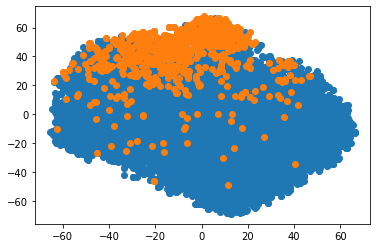

In [41]:
#@title Feature visualization { form-width: "20%" }

import matplotlib.pyplot as plt

plt.scatter(
    features_2d[(y_test_one_class==1).ravel(), 0],
    features_2d[(y_test_one_class==1).ravel(), 1]
)
plt.scatter(
    features_2d[(y_test_one_class==0).ravel(), 0],
    features_2d[(y_test_one_class==0).ravel(), 1]
)
plt.show()